# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [2]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip
        
        # Save state
        samples[attempt+1] = rpos
    
    print(f"Acceptance: {succ / attempt}")
    return samples

In [3]:
def sampleNeff(data: np.ndarray, k1percent: float = 0.0, ipercent: float = 0.4) -> int:
    N = len(data)
    k1 = int(k1percent * N)
    k2 = N-1

    icutoff = int(k2 * ipercent)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) / (Neq - i) for i in range(1, Neq)]) / (var)
    timecorr = 1 + 2 * np.sum(autocorr[:icutoff] * (autocorr[:icutoff] > 0))

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.8136418189091879
Neff: 37.40418065742761
Energy = -0.1695626807781619
Variance on Energy = 0.024010304650547314

Beta = 0.300
Acceptance: 0.7257634351246833
Neff: 49.46587251517263
Energy = -0.251268919612031
Variance on Energy = 0.027415122658909604

Beta = 0.400
Acceptance: 0.6412188291772236
Neff: 58.76027402494424
Energy = -0.32630928799341713
Variance on Energy = 0.030704072214780744

Beta = 0.500
Acceptance: 0.5750100013335111
Neff: 84.62826964969976
Energy = -0.3762598638242159
Variance on Energy = 0.03040472131856527

Beta = 0.600
Acceptance: 0.5029337244965996
Neff: 83.91860836403954
Energy = -0.4250475101451398
Variance on Energy = 0.03031658808542591

Beta = 0.700
Acceptance: 0.4615948793172423
Neff: 92.60904940629533
Energy = -0.4510979258654112
Variance on Energy = 0.021426621390836353

Beta = 0.800
Acceptance: 0.40345379383917856
Neff: 95.45101742792109
Energy = -0.4673679232465624
Variance on Energy = 0.01135438686474938

Beta = 0.900
Acceptanc

Text(0.5, 1.0, 'Parameter Sweep')

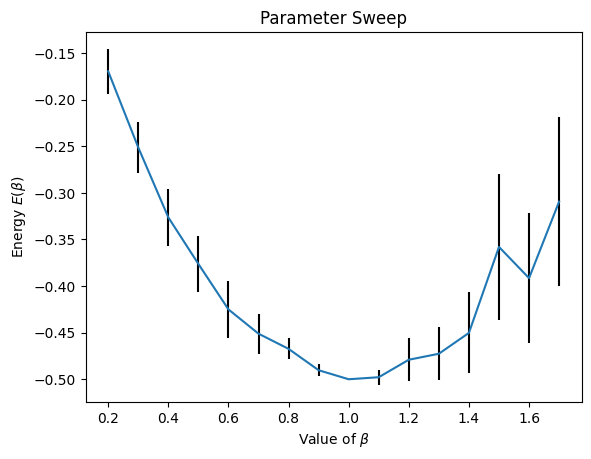

In [6]:
# Parameters
sampleM = 15000
discard = 1500

# Sweep Variational Parameter
betaMin = 0.2
betaMax = 1.7

Ebeta = []
Estd = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    print(f"Beta = {betaStart:.3f}")
    Rs = samplePos(sampleM, betaStart, delta=4)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    El = -0.5*betaStart*(betaStart - 2/Rs) - 1.0 / Rs

    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bbRange[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting

BetaMid = 2.000
Acceptance: 0.4424070678446408
Neff: 97.8709269755538

BetaMid = 1.200
Acceptance: 0.6406067677946324
Neff: 56.8587104060198

BetaMid = 1.000
Acceptance: 0.6873645607601266
Neff: 58.69275043606623

BetaMid = 1.000
Acceptance: 0.7046174362393732
Neff: 47.23528125048263

BetaMid = 1.000
Acceptance: 0.6832805467577929
Neff: 66.13826869977365

Final beta: 1.0
Minimum energy: -0.5


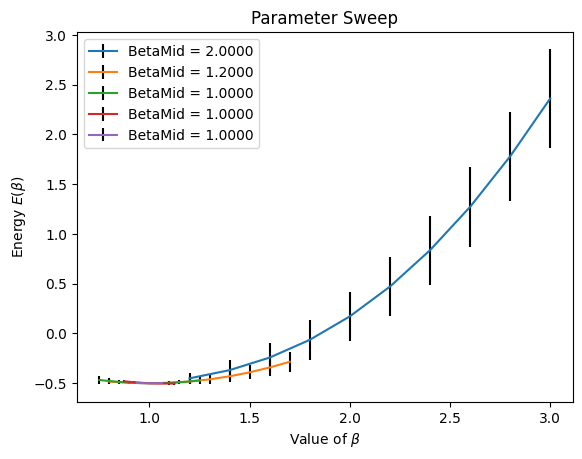

In [5]:
# Sampling Parameters
sampleM = 12000
discard = 2000

delta = 1.4

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 11
betaMult = 0.5

betaSteps = 5

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs = samplePos(sampleM, betaMid, delta=delta)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * Rs)

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)
        if m < 0.5:
            continue

        bb += [beta]

        El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")
plt.legend()